In [283]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import pymc3 as pm
import lab4_functions as lab4
import lab4_hmc as hmc
from scipy.stats import multivariate_normal
%matplotlib inline

# Exploratory Analysis

In [2]:
df_train = pd.read_csv('ee-train.csv')
df_test = pd.read_csv('ee-test.csv')
df_train.head(3)

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.62,808.5,367.5,220.5,3.5,3,0.1,5,12.74
1,0.90,563.5,318.5,122.5,7.0,3,0.1,2,29.68
2,0.90,563.5,318.5,122.5,7.0,3,0.4,2,36.57


In [3]:
df_test.head(3)

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
0,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55
1,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55
2,0.90,563.5,318.5,122.50,7.0,4,0.0,0,20.71


In [4]:
df_train.describe()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load
count,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000,384.000000
mean,0.771042,665.774740,318.180990,173.796875,5.377604,3.536458,0.236849,2.783854,22.920703
std,0.106553,88.196712,42.248972,44.852410,1.747619,1.097695,0.133306,1.567506,10.066099
min,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.400000
25%,0.690000,588.000000,294.000000,140.875000,3.500000,3.000000,0.100000,1.000000,14.057500
50%,0.760000,661.500000,318.500000,147.000000,7.000000,4.000000,0.250000,3.000000,23.605000
75%,0.860000,735.000000,343.000000,220.500000,7.000000,5.000000,0.400000,4.000000,32.052500
max,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000


In [5]:
df_train.shape

(384, 9)

In [7]:
df_train.dtypes

Relative Compactness         float64
Surface Area                 float64
Wall Area                    float64
Roof Area                    float64
Overall Height               float64
Orientation                    int64
Glazing Area                 float64
Glazing Area Distribution      int64
Heating Load                 float64
dtype: object

In [8]:
df_train['Heating Load'].value_counts()

14.50    3
28.15    3
15.16    3
13.02    2
15.55    2
        ..
31.53    1
32.31    1
28.17    1
32.24    1
28.75    1
Name: Heating Load, Length: 330, dtype: int64

### Historgram distribution

Text(0.5, 1.0, 'Distribution of Heating Load')

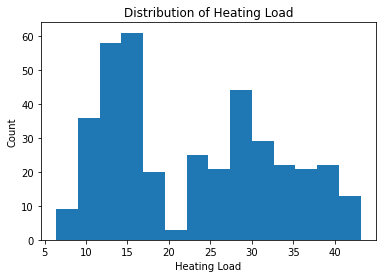

In [11]:
# Histogram of taget variable Heating Load
plt.hist(df_train['Heating Load'], bins = 14)
plt.xlabel('Heating Load')
plt.ylabel('Count')
plt.title('Distribution of Heating Load')

In [12]:
df_train.corr()['Heating Load'].sort_values()

Roof Area                   -0.851451
Surface Area                -0.656756
Orientation                  0.026561
Glazing Area Distribution    0.065567
Glazing Area                 0.256831
Wall Area                    0.436829
Relative Compactness         0.615426
Overall Height               0.882730
Heating Load                 1.000000
Name: Heating Load, dtype: float64

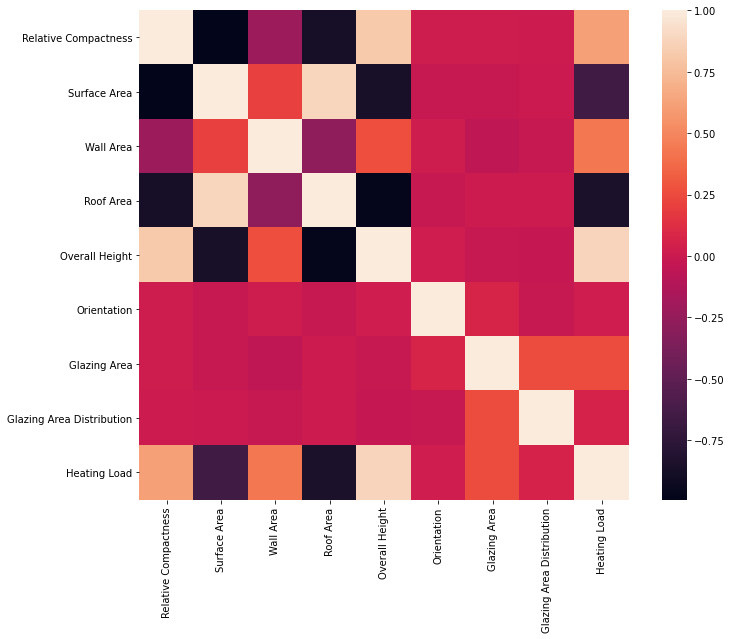

In [13]:
# heatmap features
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

/Users/IVAN/opt/anaconda3/envs/TensorTest/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


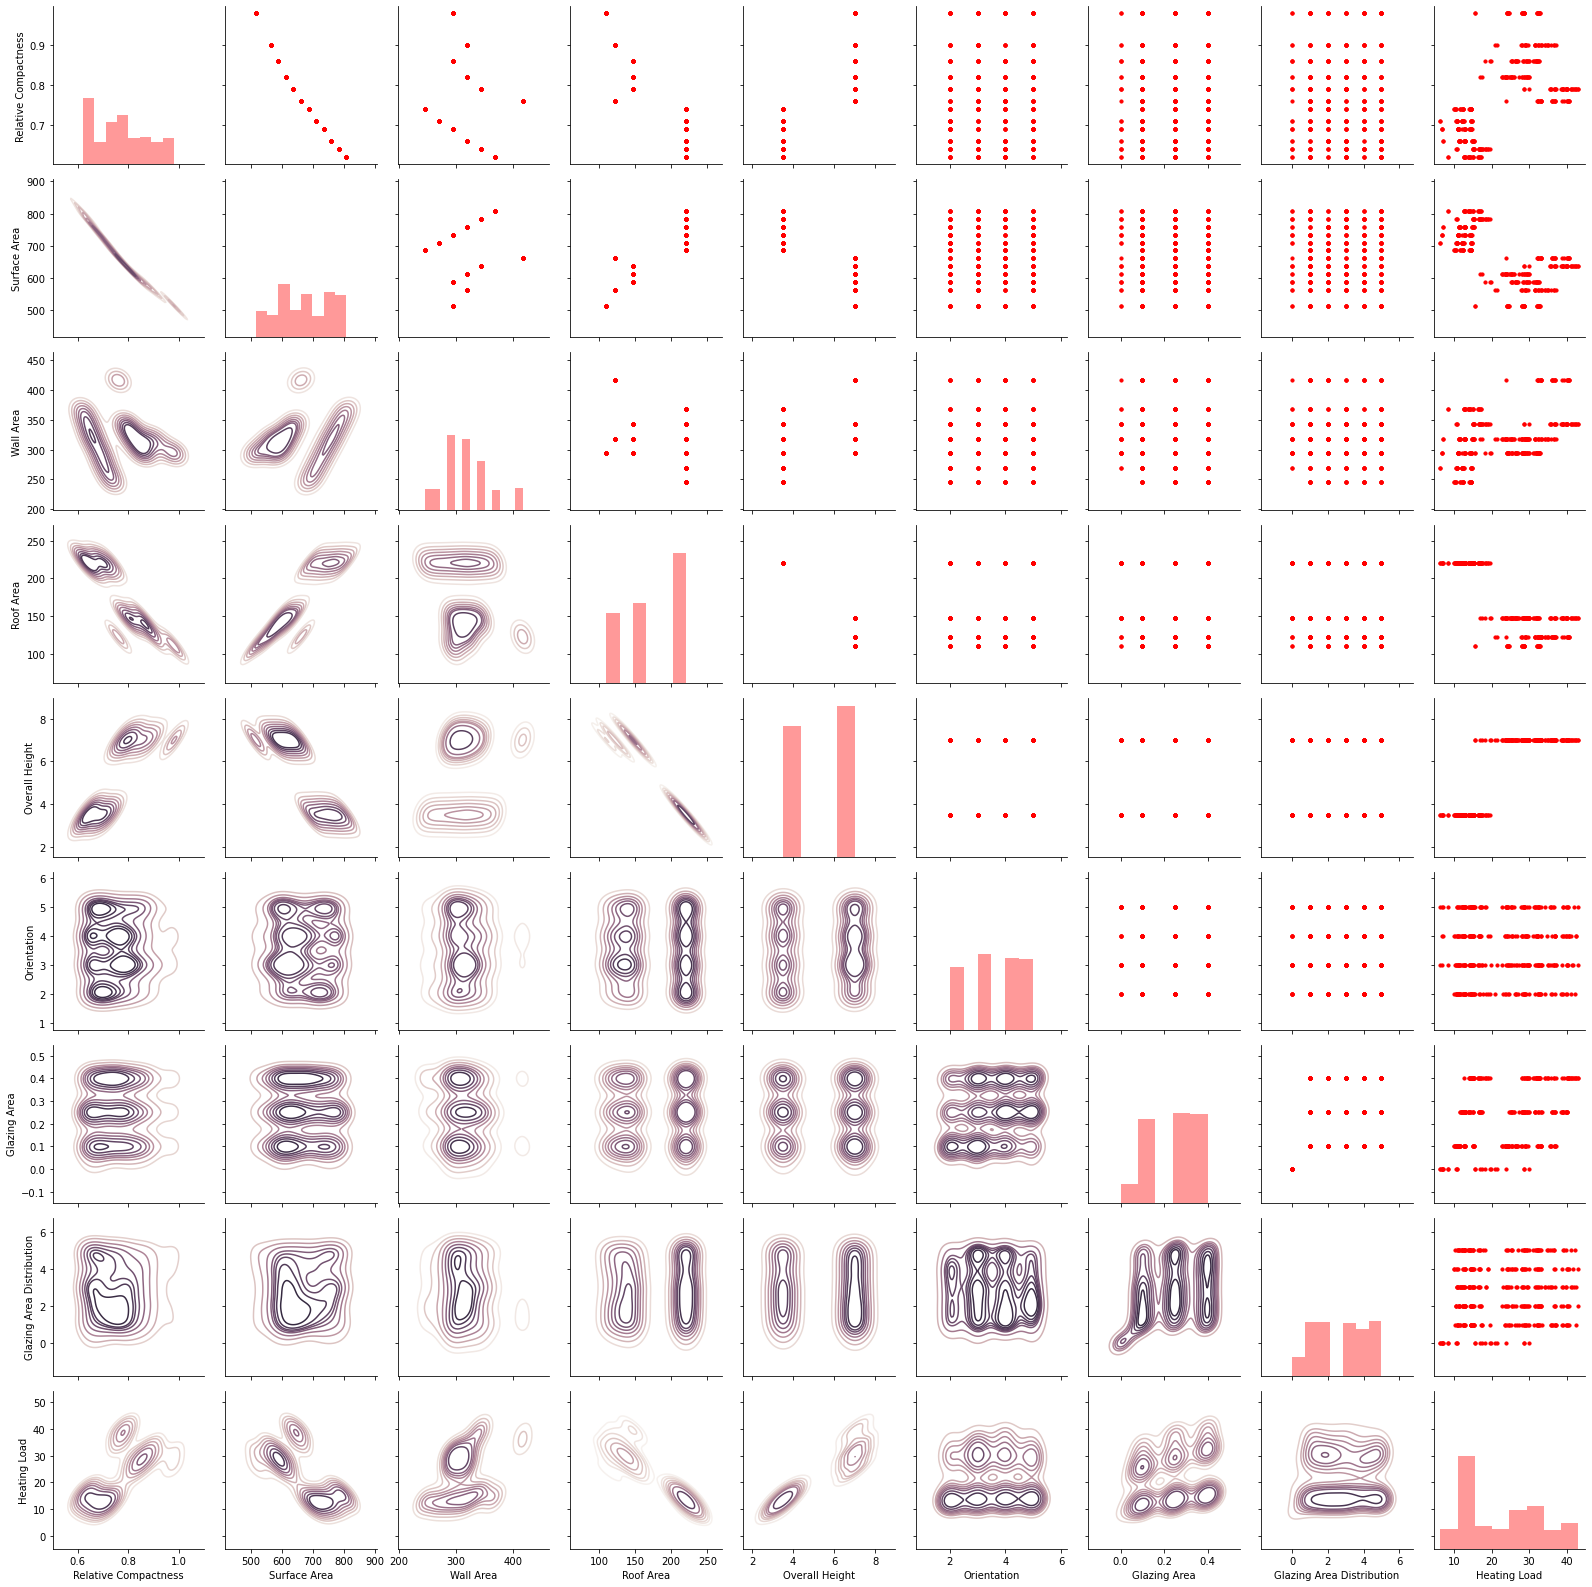

In [14]:
# pairplot...

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,hue = 0.5, as_cmap=True)
sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df_train)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

## Pre-process data

In [49]:
x_train = df_train[['Roof Area', 'Surface Area', 'Orientation', 'Glazing Area Distribution', 
        'Glazing Area', 'Wall Area', 'Relative Compactness', 'Overall Height',]]
y_train = df_train['Heating Load']
x_test = df_test[['Roof Area', 'Surface Area', 'Orientation', 'Glazing Area Distribution', 
        'Glazing Area', 'Wall Area', 'Relative Compactness', 'Overall Height',]]
y_test = df_test['Heating Load']

In [229]:
# standardise data N(0,1)

scaler = preprocessing.StandardScaler()
scaler.fit(x_train)

X_train_ = scaler.transform(x_train)
X_test_ = scaler.transform(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# add bias to X
X_train = np.hstack((np.ones((len(X_train_), 1)), X_train_))
X_test = np.hstack((np.ones((len(X_test_), 1)), X_test_))

print(X_train)
print(X_train_.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train[:5])


[[ 1.          1.0426208   1.6203718  ...  1.16886521 -1.41937931
  -1.07578035]
 [ 1.         -1.14517367 -1.16113366 ...  0.00756058  1.21185627
   0.92955778]
 [ 1.         -1.14517367 -1.16113366 ...  0.00756058  1.21185627
   0.92955778]
 ...
 [ 1.          1.0426208   1.6203718  ...  1.16886521 -1.41937931
  -1.07578035]
 [ 1.          1.0426208   0.50776962 ... -1.15374405 -0.57362502
  -1.07578035]
 [ 1.         -1.14517367 -1.16113366 ...  0.00756058  1.21185627
   0.92955778]]
(384, 8)
(384, 9)
(384, 9)
[12.74 29.68 36.57 38.57 34.72]


## Linear Regression baseline

In [589]:
def lr_fit(X, y):
    # create vector of ones as constants
    c = np.ones(shape=y.shape)[..., None]
    
    #add to feature matrix
    X = np.concatenate((c, X), axis=1)

    # calculate coefficients using closed-form solution
    coeff = np.linalg.inv(X.transpose().dot(X)).dot(X.transpose()).dot(y)

    w = coeff[1:]
    c = coeff[0]

    return c, w

def lr_pred(X, c, w):
    y_pred = c + X.dot(w)
    return y_pred

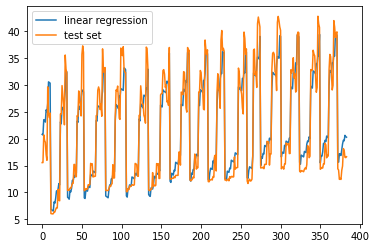

In [590]:
c, w = lr_fit(X_train_, y_train)
lr_pred_train = lr_pred(X_train_, c, w)
lr_pred = lr_pred(X_test_, c, w)

plt.plot(lr_pred, label='linear regression')
plt.plot(y_test, label='test set')
plt.legend()

In [231]:
print(c, w)

22.920703125000014 [-15.528023     8.370874    -0.12516927   0.20406265   2.77021894
  -5.17781735  -7.23462823   7.20395123]


In [232]:
# Accuracy...
print('RMSE train set =', mean_squared_error(y_train, lr_pred_train, squared=False))
print('RMSE test set =', mean_squared_error(y_test, lr_pred,squared=False))

RMSE train set = 3.25590825984771
RMSE test set = 3.0648068948181897


# Bayesian Linear Regression

### Apply the standard Bayesian linear regression model

### linear basis function

In [233]:
# basis func
PHI_train = X_train 
PHI_test = X_test
print(PHI_train.shape)

(384, 9)


In [462]:
# compute the posterior mean 𝜇 and covariance 𝚺...

sigma_e = 0.1
sigma_w = 0.2
s2_e = sigma_e**2
s2_w = sigma_w**2

alpha = 1/s2_w # TO DEFINE CORRECTLY
Mu, SIGMA = lab4.compute_posterior(PHI_train, y_train, alpha, s2_e)


print('Mu={}'.format(Mu))
print()
print('w={}'.format(w))
print()

# compute the logarithm of the marginal likelihood 
# with basis matrix 𝚽 and with hyperparameters 𝛼 and 𝜎2 ...

#lgp = lab4.compute_log_marginal(PHI_train, y_train, alph, s2)

lgp = lab4.compute_log_marginal_scipy(PHI_train, y_train, alpha, s2_e)
print('log marginal likelihood= {}'.format(lgp))

Mu=[22.9057905  -3.84737365 -3.50130282 -0.12699609  0.20126499  2.77212716
  0.8597739  -6.5891437   7.39094331]

w=[-15.528023     8.370874    -0.12516927   0.20406265   2.77021894
  -5.17781735  -7.23462823   7.20395123]

log marginal likelihood= -181933.0180955631


In [234]:
print(s2_e)
print(s2_w)
print(alpha)

0.010000000000000002
0.04000000000000001
24.999999999999996


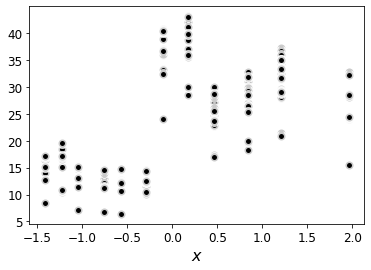

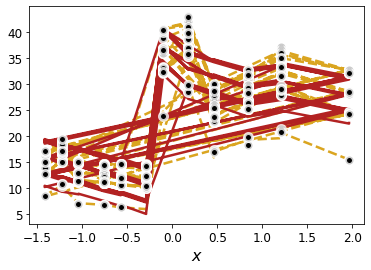

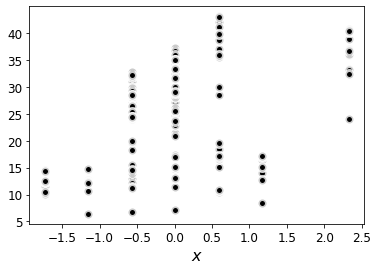

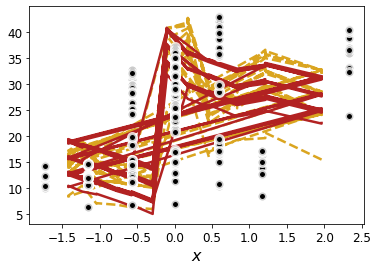

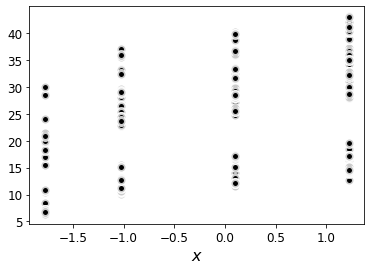

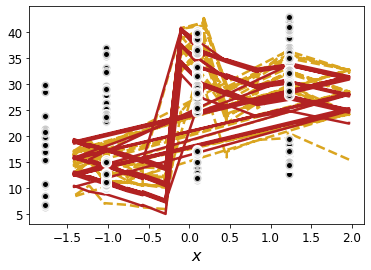

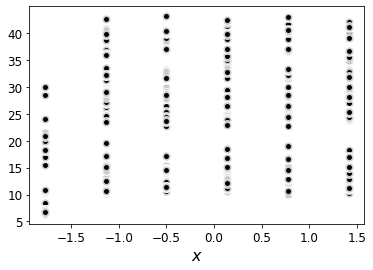

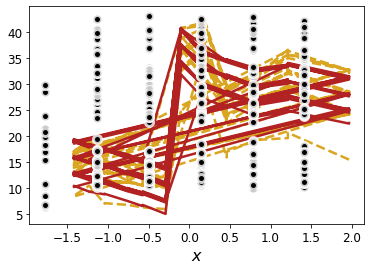

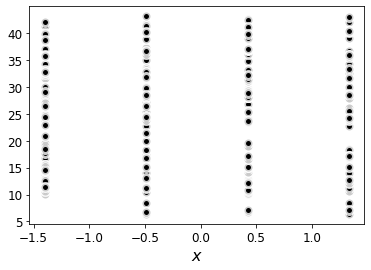

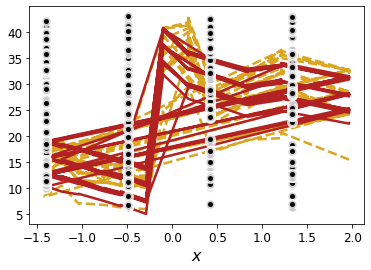

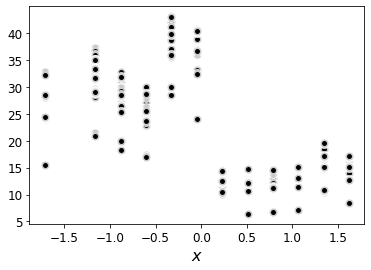

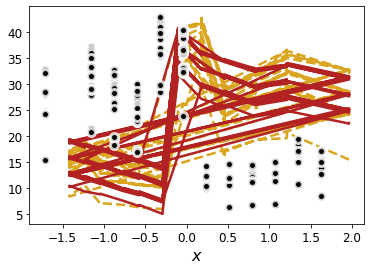

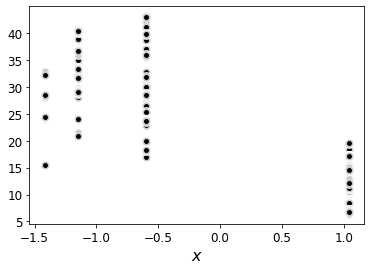

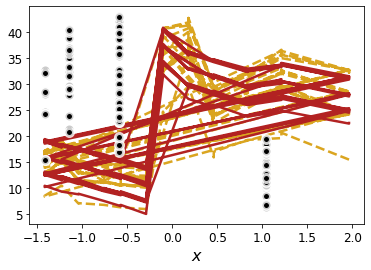

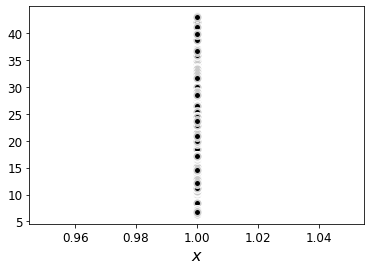

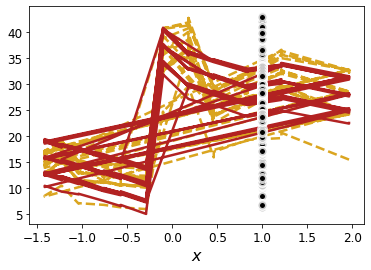

In [539]:
fy_train = PHI_train @ Mu
fy_test = PHI_test @ Mu

# Show the training data and generating function, plus our mean fit
plt1 = lab4.plot_regression(X_train[:,7], y_train)
plt.show()
plt2 = lab4.plot_regression(X_train[:,7], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt3 = lab4.plot_regression(X_train[:,6], y_train)
plt.show()
plt4 = lab4.plot_regression(X_train[:,6], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt5 = lab4.plot_regression(X_train[:,5], y_train)
plt.show()
plt6 = lab4.plot_regression(X_train[:,5], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt7 = lab4.plot_regression(X_train[:,4], y_train)
plt.show()
plt8 = lab4.plot_regression(X_train[:,4], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt9 = lab4.plot_regression(X_train[:,3], y_train)
plt.show()
plt10 = lab4.plot_regression(X_train[:,3], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt11 = lab4.plot_regression(X_train[:,2], y_train)
plt.show()
plt12 = lab4.plot_regression(X_train[:,2], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt13 = lab4.plot_regression(X_train[:,1], y_train)
plt.show()
plt14 = lab4.plot_regression(X_train[:,1], y_train, X_test[:,7], y_test, fy_test)
plt.show()
plt15 = lab4.plot_regression(X_train[:,0], y_train)
plt.show()
plt16 = lab4.plot_regression(X_train[:,0], y_train, X_test[:,7], y_test, fy_test)
plt.show()

In [237]:
# Accuracy...
print('RMSE train set =', mean_squared_error(y_train, fy_train, squared=False))
print('RMSE test set =', mean_squared_error(y_test, fy_test, squared=False))

RMSE train set = 3.0122155568070403
RMSE test set = 2.8436722134045636


## 2a. Type II  maximum likelihood

most probable coordinates: (0, 33)
most probable alpha: 0.006737946999085467 & s2: 4.5399929762484854e-05
log probabilities: -49.979155630169096
CPU times: user 17min 47s, sys: 6min 38s, total: 24min 26s
Wall time: 4min 16s


Text(0, 0.5, 'log_s2')

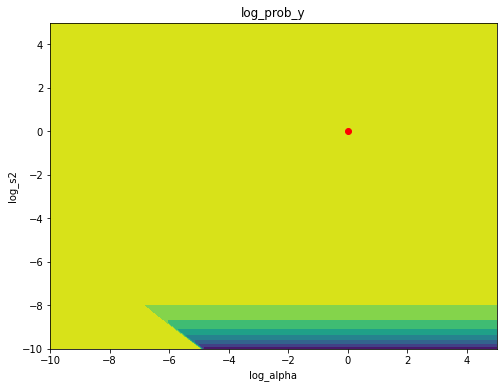

In [538]:
%%time
#### Calculate p(alpha,s2|y) and log p(alpha,s2|y) for visualisation...

# def log_prob_alph_s2_given_y(alph, s2, x, y):
# #    RBF = RBFGenerator(centres, r)
#     PHI = x
#     logML = lab4.compute_log_marginal_scipy(PHI, y, alph, s2)
#     return logML

steps = 100
log_s2 = np.linspace(-10, 5, steps)
log_alpha = np.linspace(-10, 5, steps)

log_prob_y = np.ones((steps,steps))
prob_y = np.ones((steps,steps))
                 
for i in range(steps):
    for j in range(steps):
            s2 = (np.exp(log_s2))[i]
            alph = (np.exp(log_alpha))[j]

#             log_prob_y[i,j] = (log_prob_alph_s2_given_y(alph, s2, X_train, y_train))
            log_prob_y[i,j] = (lab4.compute_log_marginal_scipy(PHI_train, y_train, alph, s2))


#### maximise the log marginal liklihood to get the most probable alpha and r values and its log probabilities
indices = np.unravel_index(log_prob_y.argmax(), log_prob_y.shape)
print('most probable coordinates: {}'.format(indices))
print('most probable alpha: {} & s2: {}'.format(np.exp(log_alpha[indices[1]]), np.exp(log_s2[indices[0]])))
print('log probabilities: {}'.format(log_prob_y[indices]))

# contour plot
fig, ax1 = plt.subplots(1, figsize=(8,6))
ax1.contourf(log_alpha, log_s2, log_prob_y)
ax1.plot(np.exp(log_alpha[indices[1]]), np.exp(log_s2[indices[0]]),'ro')
ax1.set_title('log_prob_y')
ax1.set_xlabel('log_alpha')
ax1.set_ylabel('log_s2')



most probable alpha: 0.006737946999085467 & s2: 4.5399929762484854e-05


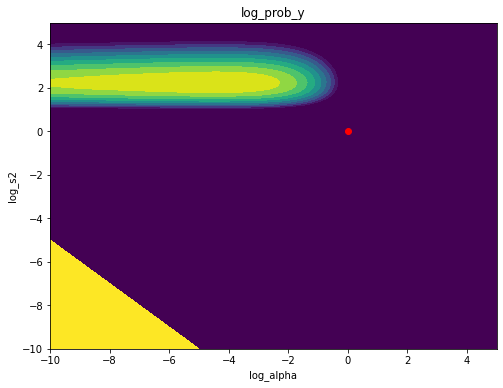

In [537]:
# contour plot with Nomalisation
import matplotlib.colors as colors
fig, ax1 = plt.subplots(1, figsize=(8,6))
vmin = -1200
vmax = -1000
norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
ax1.contourf(log_alpha, log_s2, log_prob_y, np.linspace(vmin,vmax,10), norm=norm, extend='both')
ax1.plot(np.exp(log_alpha[indices[1]]), np.exp(log_s2[indices[0]]),'ro')
ax1.set_title('log_prob_y')
ax1.set_xlabel('log_alpha')
ax1.set_ylabel('log_s2')
ax1.set_xlim(-10,5)
ax1.set_ylim(-10,5)
print('most probable alpha: {} & s2: {}'.format(np.exp(log_alpha[indices[1]]), np.exp(log_s2[indices[0]])))

In [533]:
best_alpha = np.exp(log_alpha[indices[1]])
best_s2_e = np.exp(log_s2[indices[0]])
s2_w = 1/alpha


#best_alpha = 9
#best_s2_e = 0.00002

Mu_, _ = lab4.compute_posterior(PHI_train, y_train, best_alpha, best_s2_e)
# best_lgp = lab4.compute_log_marginal_scipy(PHI_train, best_y_train, alpha, s2)
y_pred2 = PHI_test @ Mu_

In [536]:
print('LR= {}{}'.format(c, w))
print()
print('BLR={}'.format(Mu))
print()
print('Type II= {}'.format(Mu_))
print()

LR= 22.920703125000014[-15.528023     8.370874    -0.12516927   0.20406265   2.77021894
  -5.17781735  -7.23462823   7.20395123]

BLR=[22.9057905  -3.84737365 -3.50130282 -0.12699609  0.20126499  2.77212716
  0.8597739  -6.5891437   7.39094331]

Type II= [22.92070311 -4.23192346 -3.94214253 -0.12516927  0.20406264  2.77021895
  0.75594594 -7.23462732  7.2039515 ]



In [535]:
# Accuracy...
print('RMSE test set =', mean_squared_error(y_test, y_pred2, squared=False))

RMSE test set = 2.8435880266306786


## 2b. Variational Inference - Mean-Field Theory

In [547]:
# Notes 5 (10)
# conjugate Gamma hyperprior
mu_0 = 1
mu_n = 1
lam_0 = 1 
lam_n = 1
# arbitary values 10ˆ-4
a_0 = 10**-4
a_n = 1
b_0 = 10**-4
b_n = 1
counter = 1
N = X_train.shape[0]

mean = y_train.mean()
for y in y_train:
    mu_n = (lam_0 * mu_0 + counter * mean)/(lam_0+N)
    a_n = a_0 + counter/2
    b_n = b_0 + 0.5*np.sum((y_train[:counter] - mu_n)**2 + lam_0*(mu_n - mu_0)**2)
    lam_n = (lam_0 + N) * (a_n/b_n)
    counter+=1

## 2c. Variational Approximation

In [552]:
alpha_VI = 1/mu_n
print(alpha_VI)
s2_VI = (a_n / b_n)**2
print(s2_VI)
Mu_VI, _ = lab4.compute_posterior(PHI_train, y_train, alpha_VI, s2_VI)
y_pred_VI = PHI_test @ Mu_VI


0.04373732611572784
2.9820047196016876e-06


most probable alpha: 0.04373732611572784 & s2: 2.9820047196016876e-06


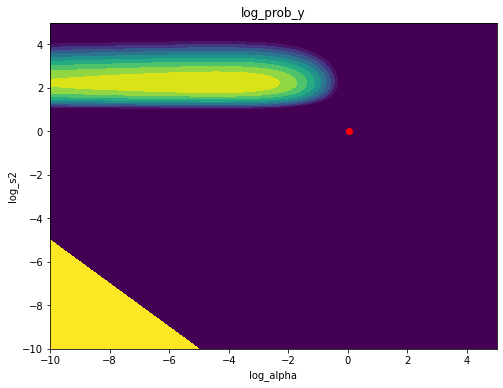

In [553]:
# contour plot with Nomalisation
fig, ax1 = plt.subplots(1, figsize=(8,6))
vmin = -1200
vmax = -1000
norm = colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
ax1.contourf(log_alpha, log_s2, log_prob_y, np.linspace(vmin,vmax,10), norm=norm, extend='both')
ax1.plot(alpha_VI, s2_VI,'ro')
ax1.set_title('log_prob_y')
ax1.set_xlabel('log_alpha')
ax1.set_ylabel('log_s2')
ax1.set_xlim(-10,5)
ax1.set_ylim(-10,5)
print('most probable alpha: {} & s2: {}'.format(alpha_VI, s2_VI))

In [554]:
print('LR= {}{}'.format(c, w))
print()
print('BLR={}'.format(Mu))
print()
print('Type II= {}'.format(Mu_))
print()
print('VI= {}'.format(Mu_VI))
print()

LR= 22.920703125000014[-15.528023     8.370874    -0.12516927   0.20406265   2.77021894
  -5.17781735  -7.23462823   7.20395123]

BLR=[22.9057905  -3.84737365 -3.50130282 -0.12699609  0.20126499  2.77212716
  0.8597739  -6.5891437   7.39094331]

Type II= [22.92070311 -4.23192346 -3.94214253 -0.12516927  0.20406264  2.77021895
  0.75594594 -7.23462732  7.2039515 ]

VI= [22.92070312 -4.23193242 -3.94213561 -0.12516927  0.20406264  2.77021894
  0.75594119 -7.23462784  7.20395134]



In [556]:
# Accuracy...
print('RMSE test set =', mean_squared_error(y_test, y_pred_VI, squared=False))

RMSE test set = 2.8435879407890936


## 3. Toy Problrm with a bivariate normal distribusion

In [284]:
n = 50 # gridsize

x1 = np.linspace(-10, 10, n)
x2 = np.linspace(-10, 10, n)
mesh = np.meshgrid(x1, x2) # Return coordinate matrices from coordinate vectors

mean = np.array([0,0])
cov = np.array([[0.5,0.2],[0.2,0.5]])

P = multivariate_normal(mean,cov)
data = P.rvs((n,2)) # Draw random samples from a multivariate normal distribution

logpdf = P.logpdf((np.array(mesh).T))

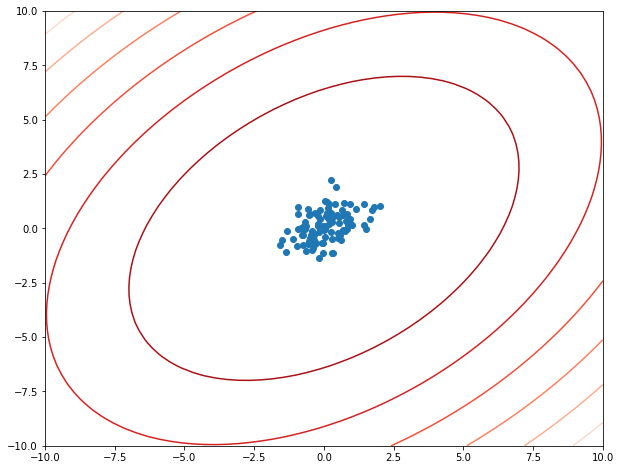

In [285]:
fsz = (10,8)
plt.figure(figsize=fsz)
plt.contour(*mesh, logpdf, cmap='Reds')
plt.scatter(*data.T)

In [286]:
def e_func(x):
    mean = np.array([0,0])
    cov = np.array([[0.5,0.2],[0.2,0.5]])
    lgp = multivariate_normal.logpdf(x,mean=mean,cov=cov)
    return -lgp

In [287]:
def e_grad(x):
    mean = np.array([0,0])
    cov = np.array([[0.5,0.2],[0.2,0.5]])
    return np.dot((x-mean).T, np.linalg.inv(cov))

In [288]:
# Initial state: something random and sensible
x0 = np.random.normal(size=2)
hmc.gradient_check(x0, e_func, e_grad)

Calc.         Numeric       Delta         Acc.
   -0.848496     -0.848496  -9.424950e-11  10
     1.83762       1.83762   5.047585e-11  11


Calc.         Numeric       Delta         Acc.
   -0.848496     -0.848496  -9.424950e-11  10
     1.83762       1.83762   5.047585e-11  11
|----------|  0% accepted [ 11 secs to go ]
|#---------| 82% accepted [ 10 secs to go ]
|##--------| 82% accepted [ 9 secs to go ]
|###-------| 81% accepted [ 8 secs to go ]
|####------| 81% accepted [ 7 secs to go ]
|#####-----| 81% accepted [ 6 secs to go ]
|######----| 81% accepted [ 5 secs to go ]
|#######---| 81% accepted [ 4 secs to go ]
|########--| 81% accepted [ 2 secs to go ]
|#########-| 81% accepted [ 1 secs to go ]
|##########| 81% accepted [ 0 secs to go ]
HMC: R=10000 / L=25 / eps=0.8 / Accept=81.1%


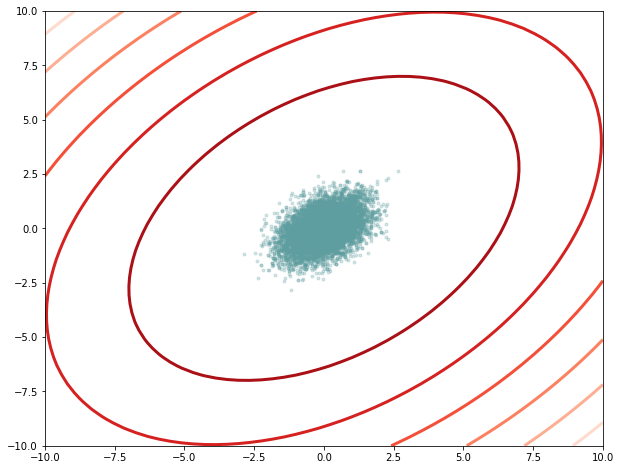

In [289]:
#
np.random.seed(seed=1)  # For reproducibility
R = 10000  # More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 25  # OK here (should be larger in regression sampling)
eps = 0.8  # Trial-and-error ... feel free to experiment!
#
S, *_ = hmc.sample(x0, e_func, e_grad, R, L, eps, burn=burn, checkgrad=True)
#
plt.figure(figsize=fsz)
plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.contour(*mesh, logpdf, cmap='Reds', linewidths=3, zorder=1);

## 4. Apply HMC on Linear Regression Model

In [471]:
# weights + s2 + alpha posterior
def e_func_lr(x, X_train, y_train):
    N, M = X_train.shape
    w = x[:M]
    alpha = x[M]
    s2 = x[M+1]
    
    y_hat = X_train @ w
    liklihood = ((-N/2) * np.log(2*np.pi*s2)) - ((1/(2*s2))*np.sum((y_train - y_hat)**2))
    # notes 8 (4.2)
    w_prior = ((M/2)*np.log(alpha/(2*np.pi)))-((alpha/2)*np.sum(w**2))
    
    lgp = liklihood + w_prior

    return -lgp

In [497]:
def e_grad_lr(x, X_train, y_train):    
    
    N, M = X_train.shape
    w = x[:M]
    alpha = x[M]
    s2 = x[M+1]
    
    y_hat = X_train @ w
    
    # 11 gradients
    grad = np.ones(M+2)
    # calc gradient of weights
    for i in range(M):
        grad[i] = (-1/(2*s2))*(np.sum(2*X_train[:,i]*(y_train - y_hat)))+(alpha * w[i])
    # calc gradient of alpha ()
    grad[M] = -0.5*(M/alpha - np.sum(w**2))
 
    # calc gradient of s2
    grad[M+1] = 0.5* (N/s2 - (np.sum((y_train - y_hat)**2)/(s2**2)))
    
    return grad

In [499]:
# Initial state: something random and sensible
#x0 = np.random.normal(size=11)
x0 = np.random.uniform(size=X_train.shape[1]+2)
hmc.gradient_check(x0, e_func_lr, e_grad_lr, X_train, y_train)

Calc.         Numeric       Delta         Acc.
    -13284.8      -13284.8   1.246539e-05  10
     5494.12       5494.12   2.646321e-06  10
     4484.86       4484.86  -4.012938e-06  10
     376.612       376.612   1.714459e-06   9
     -30.425       -30.425   7.691548e-06   7
    -1319.46      -1319.46   3.082565e-06   9
    -2302.76      -2302.76   8.465136e-06   9
    -4232.72      -4232.72  -5.280446e-06   9
     -5664.5       -5664.5  -9.880770e-06   9
    -6.28485      -6.28484   4.231183e-06   7
     -279910       -279910  -2.073764e-06  12


In [592]:
#
np.random.seed(seed=1)  # For reproducibility
R = 5000  # 10000 More than really needed, but produces a nice dense plot
burn = int(R/10)  # A reasonable rule-of-thumb
L = 100  # 25 OK here (should be larger in regression sampling)
eps = 0.0025  # Trial-and-error ... feel free to experiment!
#
# pass data to the sampler as args
S, *_ = hmc.sample(x0, e_func_lr, e_grad_lr, R, L, eps, burn=burn, checkgrad=True, args=[X_train, y_train])
#

# take average of output distribution

mean_alpha = np.mean(S[:,9])
mean_s2 = np.mean(S[:,10])
mean_w = np.mean(S[:,:9], axis=0)

# fsz = (10,8)
# plt.figure(figsize=fsz)
# plt.plot(S[:, 0], S[:, 1], '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
# plt.contour(*mesh, logpdf, cmap='Reds', linewidths=3, zorder=1);

Calc.         Numeric       Delta         Acc.
    -13284.8      -13284.8   1.246539e-05  10
     5494.12       5494.12   2.646321e-06  10
     4484.86       4484.86  -4.012938e-06  10
     376.612       376.612   1.714459e-06   9
     -30.425       -30.425   7.691548e-06   7
    -1319.46      -1319.46   3.082565e-06   9
    -2302.76      -2302.76   8.465136e-06   9
    -4232.72      -4232.72  -5.280446e-06   9
     -5664.5       -5664.5  -9.880770e-06   9
    -6.28485      -6.28484   4.231183e-06   7
     -279910       -279910  -2.073764e-06  12
|----------|  0% accepted [ 68 secs to go ]
|#---------| 94% accepted [ 62 secs to go ]
|##--------| 95% accepted [ 55 secs to go ]
|###-------| 95% accepted [ 48 secs to go ]
|####------| 93% accepted [ 41 secs to go ]
|#####-----| 93% accepted [ 35 secs to go ]
|######----| 93% accepted [ 28 secs to go ]
|#######---| 93% accepted [ 21 secs to go ]
|########--| 93% accepted [ 14 secs to go ]
|#########-| 93% accepted [ 7 secs to go ]
|#######

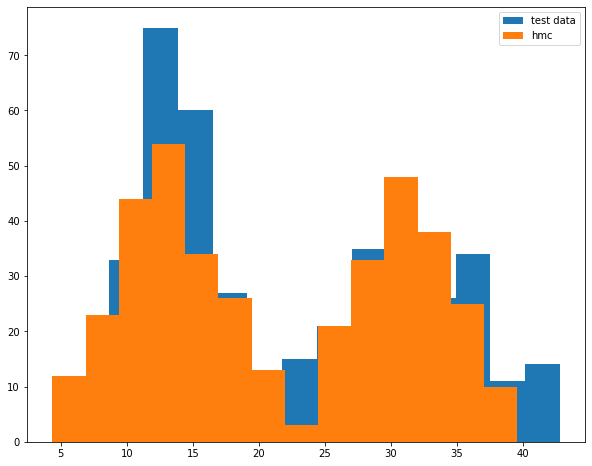

In [578]:
plt.figure(figsize=fsz)
#plt.scatter(y_test, y_pred_hmc, '.', ms=6, color='CadetBlue', alpha=0.25, zorder=0)
plt.hist(y_test, bins = 14, label='test data')
plt.hist(y_pred_hmc, bins = 14, label = 'hmc')
plt.legend()

In [519]:
# prediction output
y_pred_hmc = X_test @ mean_w

# Accuracy
print('RMSE test set =', mean_squared_error(y_test, y_pred_hmc, squared=False))


RMSE test set = 2.918417057685652


In [555]:
# all weights summary
print('LR= {}{}'.format(c, w))
print()
print('BLR={}'.format(Mu))
print()
print('Type II= {}'.format(Mu_))
print()
print('VI= {}'.format(Mu_VI))
print()
print('HMC= {}'.format(mean_w))

LR= 22.920703125000014[-15.528023     8.370874    -0.12516927   0.20406265   2.77021894
  -5.17781735  -7.23462823   7.20395123]

BLR=[22.9057905  -3.84737365 -3.50130282 -0.12699609  0.20126499  2.77212716
  0.8597739  -6.5891437   7.39094331]

Type II= [22.92070311 -4.23192346 -3.94214253 -0.12516927  0.20406264  2.77021895
  0.75594594 -7.23462732  7.2039515 ]

VI= [22.92070312 -4.23193242 -3.94213561 -0.12516927  0.20406264  2.77021894
  0.75594119 -7.23462784  7.20395134]

HMC= [22.78431382 -2.32320696  3.32359735 -0.07140926  0.18850128  2.78463323
  0.60810177 -0.44020887  9.71892219]


In [557]:
# all results summary

print('RMSE test set for Linear Regression=', mean_squared_error(y_test, lr_pred, squared=False))
print('RMSE test set for standard Bayesian LR=', mean_squared_error(y_test, fy_test, squared=False))
print('RMSE test set for Type II Bayesian=', mean_squared_error(y_test, y_pred2, squared=False))
print('RMSE test set for Variational Approximation=', mean_squared_error(y_test, y_pred_VI, squared=False))
print('RMSE test set for HMC=', mean_squared_error(y_test, y_pred_hmc, squared=False))

RMSE test set for Linear Regression= 3.0648068948181897
RMSE test set for standard Bayesian LR= 2.8436722134045636
RMSE test set for Type II Bayesian= 2.8435880266306786
RMSE test set for Variational Approximation= 2.8435879407890936
RMSE test set for HMC= 2.918417057685652


In [426]:
S.shape

(5000, 11)